## Метод cross entropy для дискретного случая
Среда - клеточный мир размером 1х6
![title](environment.png)

Цель: достижение терминального состояния за минимальное количество действий

### Для нахождения решения необходимо описать 
- среду
- награду
- политику

#### Среда
Содержит 5 клеток с терминальным состоянием. Агент может перемещаться из каждого состояния влево или вправо. 

#### Награда
За каждый шаг штрафуем агента, стимулируя его закончить сессию как можно скорее

#### Политика
Политика - это распределение вероятностей по действиям при фиксированном состоянии

policy[s,a] = P(take action a | in state s)

## Среда 

In [1]:
import numpy as np

In [2]:
class env:
    def __init__(self,num_cells):
        
        self.num_cells = num_cells
        self.state = 0
        self.is_done = False
        
    def step(self,a):
        
        if a == 0:
            a = -1
        
        if a == -1 and self.state == 0:
            self.state = 0            
        elif self.state == self.num_cells-1:
            self.is_done = True  
        else:
            self.state = self.state + a
        return self.state
            
            
    def reset(self):
        self.state = 0
        self.is_done = False       
        

In [3]:
def start_policy(env):
    policy = np.ones((env.num_cells,2))/2
    return policy

t = env(5)
policy = start_policy(t)
print(policy)

[[0.5 0.5]
 [0.5 0.5]
 [0.5 0.5]
 [0.5 0.5]
 [0.5 0.5]]


In [4]:
t = env(5)
policy = start_policy(t)
p = policy[t.state]
a = np.random.choice(list(range(2)),p = policy[t.state])
print(p)
print(t.is_done)
print(a)

[0.5 0.5]
False
0


In [9]:
list(range(2))

[0, 1]

In [10]:
new_s = t.step(a)
print(t.is_done == False)

print(new_s)

True
0


In [11]:
def generate_sessions(env,policy,num_sells):
    states, actions = [], []
    total_reward = 0
    
    s = env(num_sells)
    state = 0
    
    while s.is_done == False:
        
        states.append(state)
        
        total_reward += -1
        
        a = np.random.choice(list(range(2)),p = policy[state])
        actions.append(a)
        
        state = s.step(a)   
        
        if state == num_sells-1:
            s.reset()
            break      
                 
            
    return states , actions, total_reward
        

In [16]:

states , actions, total_reward = generate_sessions(env,policy,5)

In [17]:
print(states)

[0, 1, 0, 1, 2, 1, 0, 0, 0, 0, 0, 1, 2, 1, 2, 3, 2, 3, 2, 3]


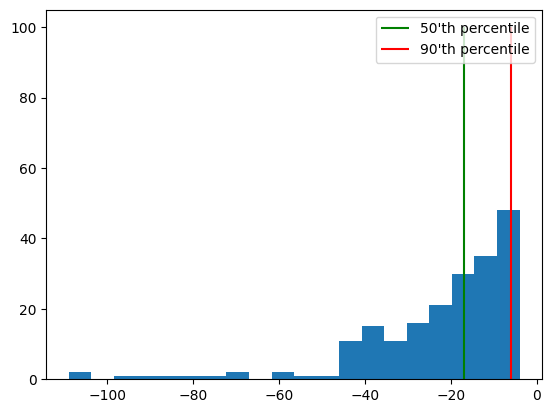

In [19]:
# let's see the initial reward distribution
import matplotlib.pyplot as plt
#%matplotlib inline

sample_rewards = [generate_sessions(env, policy, 5)[-1] for _ in range(200)]

plt.hist(sample_rewards, bins=20)
plt.vlines([np.percentile(sample_rewards, 50)], [0], [100], label="50'th percentile", color='green')
plt.vlines([np.percentile(sample_rewards, 90)], [0], [100], label="90'th percentile", color='red')
plt.legend()

## Метод кросс энтропии

In [20]:

def select_elites(states_batch, actions_batch, rewards_batch, percentile):
    

    # reward_threshold = <YOUR CODE: 

    # elite_states = <YOUR CODE>
    # elite_actions = <YOUR CODE>
    #============================================
    reward_threshold = np.percentile(rewards_batch,percentile)
    
    elite_states = []
    elite_actions = []
    
    for i in range(len(states_batch)):
        if rewards_batch[i] >= reward_threshold:
            elite_states.extend(states_batch[i])
            elite_actions.extend(actions_batch[i])

    return elite_states, elite_actions

In [22]:
states_batch = [
    [0, 1, 2,3,4],     # game1
    [0, 0, 1, 2],  # game2
    [1, 1],        # game3
]

actions_batch = [
    [0, 1, 1,1,1],     # game1
    [0, 0, 1, 1],  # game2
    [1, 0],        # game3
]
rewards_batch = [
    -6,  # game1
    -4,  # game2
    -2,  # game3
]

test_result_0 = select_elites(states_batch, actions_batch, rewards_batch, percentile=0)
test_result_30 = select_elites(states_batch, actions_batch, rewards_batch, percentile=30)
test_result_90 = select_elites(states_batch, actions_batch, rewards_batch, percentile=90)
test_result_100 = select_elites(states_batch, actions_batch, rewards_batch, percentile=100)

In [24]:
def initialize_policy(n_states, n_actions):

    policy = np.ones((n_states,n_actions))/n_actions
    return policy

policy = initialize_policy(5, 2)

In [28]:
policy = initialize_policy(5, 2)
n_sessions = 10
sessions = [ generate_sessions(env,policy,5) for i in range(n_sessions)]
states_batch, actions_batch, rewards_batch = zip(*sessions)

test_result_0 = select_elites(states_batch, actions_batch, rewards_batch, percentile=0)
test_result_30 = select_elites(states_batch, actions_batch, rewards_batch, percentile=30)
test_result_90 = select_elites(states_batch, actions_batch, rewards_batch, percentile=90)
test_result_100 = select_elites(states_batch, actions_batch, rewards_batch, percentile=100)

test_result_90

([0, 0, 0, 0, 0, 1, 2, 3, 0, 0, 0, 1, 2, 1, 2, 3],
 [0, 0, 0, 0, 1, 1, 1, 1, 0, 0, 1, 1, 0, 1, 1, 1])

In [29]:
def get_new_policy(elite_states, elite_actions):
    """

    """
    n_states = 5
    n_actions = 2
    new_policy = np.zeros([5, 2])
    
    #=============================
    for i in range(len(elite_states)):
        new_policy[elite_states[i],elite_actions[i]] += 1
        
    for i in range(n_states):
        if np.sum(new_policy[i])>0:
            new_policy[i] /= new_policy[i].sum()
        else:
            new_policy[i] = np.ones(n_actions)/n_actions
    #==============================
    return new_policy


In [30]:


test_result_50 = select_elites(states_batch, actions_batch, rewards_batch, percentile=50)
new_pol = get_new_policy(states_batch, actions_batch)
print(new_pol)

[[0.47368421 0.52631579]
 [0.41176471 0.58823529]
 [0.41176471 0.58823529]
 [0.33333333 0.66666667]
 [0.5        0.5       ]]


In [31]:
def initialize_policy(n_states, n_actions):

    policy = np.ones((n_states,n_actions))/n_actions
    return policy

policy = initialize_policy(5, 2)



## Цикл обучени

In [32]:
from IPython.display import clear_output

def show_progress(rewards_batch, log, percentile, reward_range=[-990, +10]):


    mean_reward = np.mean(rewards_batch)
    threshold = np.percentile(rewards_batch, percentile)
    log.append([mean_reward, threshold])
    
    plt.figure(figsize=[8, 4])
    plt.subplot(1, 2, 1)
    plt.plot(list(zip(*log))[0], label='Mean rewards')
    plt.plot(list(zip(*log))[1], label='Reward thresholds')
    plt.legend()
    plt.grid()

    plt.subplot(1, 2, 2)
    plt.hist(rewards_batch, range=reward_range)
    plt.vlines([np.percentile(rewards_batch, percentile)],
               [0], [100], label="percentile", color='red')
    plt.legend()
    plt.grid()
    clear_output(True)
    print("mean reward = %.3f, threshold=%.3f" % (mean_reward, threshold))
    plt.show()

In [33]:
policy = initialize_policy(5, 2)



mean reward = -5.400, threshold=-4.000


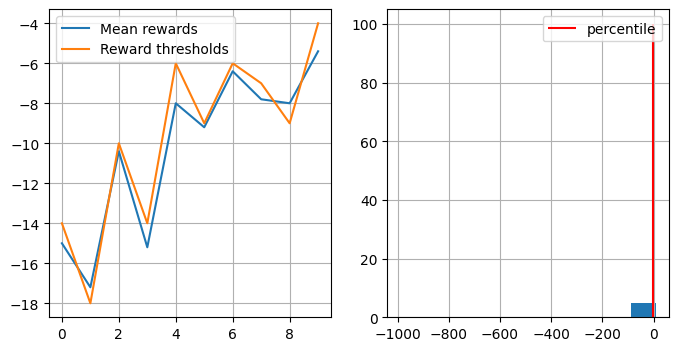

In [34]:
n_sessions = 5     # sample this many sessions
percentile = 50      # discard this percentage of sessions with lowest rewards
learning_rate = 0.5  # how quickly the policy is updated, on a scale from 0 to 1
sessions = []
log = []
elite_states = []
elite_actions = []
for i in range(10):
    
    #%time sessions = [ <YOUR CODE: generate a list of n_sessions new sessions> ]
    #================================
    #%time 
    sessions = [ generate_sessions(env,policy,5) for i in range(n_sessions)]
    #=================
    states_batch, actions_batch, rewards_batch = zip(*sessions)
    
    #============================
    #elite_states, elite_actions = <YOUR CODE: select elite states & actions>
    elite_states, elite_actions = select_elites(states_batch, actions_batch, rewards_batch, percentile=50)

    # new_policy = <YOUR CODE: compute new policy>
    new_policy = get_new_policy(elite_states,elite_actions)
    #new_policy = update_policy(elite_states,elite_actions)
  
    policy = learning_rate * new_policy + (1 - learning_rate) * policy
   
    # display results on chart
    show_progress(rewards_batch, log, percentile)

In [35]:
print(policy)

[[0.27563121 0.72436879]
 [0.11259223 0.88740777]
 [0.00419922 0.99580078]
 [0.00844727 0.99155273]
 [0.5        0.5       ]]
